In [1]:
#Standard python imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Stats imports
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multicomp as mc
import scipy.stats as stats

#random seed for replicability
np.random.seed(seed=42)

In [2]:
chi_df = pd.read_csv('../data/chi_df_cleaned.csv')
chi_df.head(2)

,severity,start_lat,start_lng,end_lat,end_lng,distance(mi),temperature(f),wind_chill(f),humidity(%),pressure(in),...,hour_22,hour_23,weather_condition_Light Snow with Thunder,weather_condition_Smoke / Windy,weather_condition_Light Snow and Sleet,weather_condition_Haze / Windy,weather_condition_Heavy Snow / Windy,weather_condition_Blowing Dust / Windy,weather_condition_Heavy Blowing Snow,is_DST
0,2,42.30596,-87.96015,42.306916,-87.960918,0.077,37.0,31.0,79.0,29.59,...,0,0,0,0,0,0,0,0,0,0
1,2,42.17587,-88.13577,42.174620,-88.135794,0.086,37.0,28.1,76.0,29.62,...,0,0,0,0,0,0,0,0,0,0


## ANOVA on severity of accidents for Spring DST Time Change

In [3]:
#I (CH) referenced this article for a refresher on ANOVA and to find the libraries to use for each test
#https://www.pythonfordatascience.org/anova-python/#anova-test
#I referenced these pages for a refresher on ANOVA vs. Kruskall-Wallace and the impact of a non-normal distribution
# https://stats.stackexchange.com/questions/76059/difference-between-anova-and-kruskal-wallis-test
# http://www.biostathandbook.com/kruskalwallis.html

In [4]:
#Spring DST Time Change ANOVA
stats.f_oneway(chi_df['severity'][chi_df['week'] == 10],
              chi_df['severity'][chi_df['week'] == 11],
              chi_df['severity'][chi_df['week'] == 12])

F_onewayResult(statistic=8.688793448084233, pvalue=0.00017439777178230329)

In [5]:
#Spring DST Time Change Kruskall-Wallace
stats.kruskal(chi_df['severity'][chi_df['week'] == 10],
              chi_df['severity'][chi_df['week'] == 11],
              chi_df['severity'][chi_df['week'] == 12])

KruskalResult(statistic=16.609003084980962, pvalue=0.000247400632235319)

In [6]:
#Fall DST Time Change ANOVA
stats.f_oneway(chi_df['severity'][chi_df['week'] == 44],
              chi_df['severity'][chi_df['week'] == 45],
              chi_df['severity'][chi_df['week'] == 46])

F_onewayResult(statistic=0.20600694424410165, pvalue=0.8138414290480289)

In [7]:
#Fall DST Time Change Kruskall-Wallace
stats.kruskal(chi_df['severity'][chi_df['week'] == 44],
              chi_df['severity'][chi_df['week'] == 45],
              chi_df['severity'][chi_df['week'] == 46])

KruskalResult(statistic=0.023728434732062008, pvalue=0.9882058849505668)

In [8]:
chi_df_spring_dst =  chi_df[(chi_df['week'] == 10) | (chi_df['week'] == 11) | (chi_df['week'] == 12)]
chi_df_spring_dst['week'].value_counts()

11    918
12    714
10    540
Name: week, dtype: int64

In [29]:
#from https://machinelearningmastery.com/chi-squared-test-for-machine-learning/
stat, p, dof, expected = stats.chi2_contingency(chi_df_spring_dst['severity'])
print('dof=%d' % dof)
print(expected)

prob = 0.95
critical = stats.chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

dof=0
[3. 3. 3. ... 3. 3. 3.]
Independent (fail to reject H0)


In [9]:
chi_df_fall_dst = chi_df[(chi_df['week'] == 44) | (chi_df['week'] == 45) | (chi_df['week'] == 46)]
chi_df_fall_dst['week'].value_counts()

45    889
44    859
46    721
Name: week, dtype: int64

In [15]:
stats.kruskal(chi_df['severity'][chi_df['week'] == 10],
              chi_df['severity'][chi_df['week'] == 11],
              chi_df['severity'][chi_df['week'] == 12])

KruskalResult(statistic=16.609003084980962, pvalue=0.000247400632235319)

In [10]:
#Statsmodel ANOVA for cleaner tables and use in multiple comparison tests
chi_spring_anova = ols("severity ~C(week)", data=chi_df_spring_dst).fit()
chi_spr_aov_table = sm.stats.anova_lm(chi_spring_anova, typ=2)
chi_spr_aov_table

,sum_sq,df,F,PR(>F)
C(week),6.234790,2.0,8.688793,0.000174
Residual,778.201214,2169.0,NaN,NaN


In [25]:
chi_spr_aov_table.to_clipboard()

In [11]:
#Recheck of initial results from scipy.stats
#Reaffirms there is no difference between the weeks, so no reason to run a comparison test
chi_fall_anova = ols("severity ~C(week)", data=chi_df_fall_dst).fit()
chi_fall_aov_table = sm.stats.anova_lm(chi_fall_anova, typ=2)
chi_fall_aov_table

,sum_sq,df,F,PR(>F)
C(week),0.150841,2.0,0.206007,0.813841
Residual,902.821212,2466.0,NaN,NaN


In [40]:
eta_square = chi_spr_aov_table[:-1]['sum_sq'] / sum(chi_spr_aov_table['sum_sq'])
eta_square

C(week)    0.007948
Name: sum_sq, dtype: float64

In [12]:
#Shapiro test of normality, failed as the severity of accidents is not normally distributed
stats.shapiro(chi_spring_anova.resid)

ShapiroResult(statistic=0.8185059428215027, pvalue=3.363116314379561e-44)

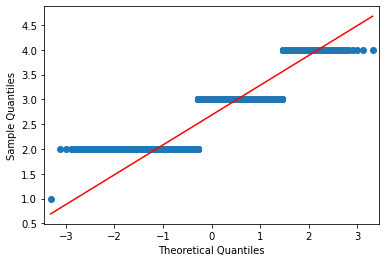

In [13]:
#QQ plot to conform lack of normality
sm.qqplot(chi_df_spring_dst['severity'], line='s');

In [14]:
#Levene's test of 
stats.levene(chi_df['severity'][chi_df['week'] == 10],
              chi_df['severity'][chi_df['week'] == 11],
              chi_df['severity'][chi_df['week'] == 12])

LeveneResult(statistic=2.2096940010363624, pvalue=0.10998119275827695)

### Tukey Honestly Significant Difference (HSD) Test

In [16]:
chi_df_spring_dst['week'] = chi_df_spring_dst.week.map({10 : 'Week Before', 11 : 'Week of DST', 12: 'Week After'})
chi_df_spring_dst.head()

<ipython-input-16-ddc561bb7eaa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chi_df_spring_dst['week'] = chi_df_spring_dst.week.map({10 : 'Week Before', 11 : 'Week of DST', 12: 'Week After'})


,severity,start_lat,start_lng,end_lat,end_lng,distance(mi),temperature(f),wind_chill(f),humidity(%),pressure(in),...,hour_22,hour_23,weather_condition_Light Snow with Thunder,weather_condition_Smoke / Windy,weather_condition_Light Snow and Sleet,weather_condition_Haze / Windy,weather_condition_Heavy Snow / Windy,weather_condition_Blowing Dust / Windy,weather_condition_Heavy Blowing Snow,is_DST
10029,3,41.95184,-87.72775,41.94999,-87.72449,0.211,33.1,22.6,72.0,30.35,...,0,0,0,0,0,0,0,0,0,0
10030,3,41.72170,-87.62416,41.72734,-87.62431,0.390,34.0,25.0,64.0,30.38,...,0,0,0,0,0,0,0,0,0,0
10031,3,41.65813,-87.58708,41.66223,-87.59059,0.336,33.4,23.5,67.0,30.31,...,0,0,0,0,0,0,0,0,0,0
10032,2,41.81494,-87.74954,41.81904,-87.73663,0.723,33.1,23.9,66.0,30.31,...,0,0,0,0,0,0,0,0,0,0
10033,2,41.94842,-87.72163,41.94331,-87.71689,0.429,37.0,28.9,65.0,30.25,...,0,0,0,0,0,0,0,0,0,0


In [17]:
chi_df_spring_dst['week'].value_counts()

Week of DST    918
Week After     714
Week Before    540
Name: week, dtype: int64

In [18]:
comp = mc.MultiComparison(chi_df_spring_dst['severity'], chi_df_spring_dst['week'], 
                         group_order=['Week Before', 'Week of DST', 'Week After'])
post_hoc = comp.tukeyhsd()
post_hoc.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Week Before,Week of DST,-0.1329,0.001,-0.2091,-0.0567,True
Week Before,Week After,-0.0618,0.1672,-0.1419,0.0183,False
Week of DST,Week After,0.0711,0.0459,0.001,0.1412,True


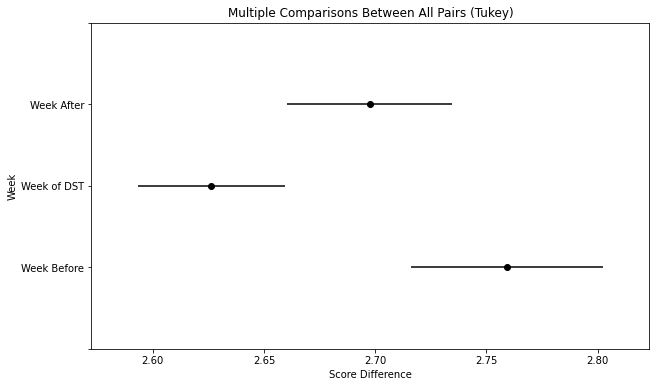

In [19]:
post_hoc.plot_simultaneous(ylabel='Week', xlabel='Score Difference');

### Bonferroni Correction

In [20]:
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method='bonf')
tbl

group1,group2,stat,pval,pval_corr,reject
Week Before,Week of DST,4.0866,0.0,0.0001,True
Week Before,Week After,1.7884,0.0739,0.2218,False
Week of DST,Week After,-2.4028,0.0164,0.0491,True


In [21]:
chi_df_spring_dst.groupby('week').mean()

,severity,start_lat,start_lng,end_lat,end_lng,distance(mi),temperature(f),wind_chill(f),humidity(%),pressure(in),...,hour_22,hour_23,weather_condition_Light Snow with Thunder,weather_condition_Smoke / Windy,weather_condition_Light Snow and Sleet,weather_condition_Haze / Windy,weather_condition_Heavy Snow / Windy,weather_condition_Blowing Dust / Windy,weather_condition_Heavy Blowing Snow,is_DST
week,,,,,,,,,,,,,,,,,,,,,
Week After,2.697479,41.938544,-87.859321,41.938944,-87.859486,0.228887,44.143137,40.588095,70.200280,29.822913,...,0.019608,0.036415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Week Before,2.759259,41.971090,-87.844087,41.971160,-87.844042,0.378793,41.404630,36.361667,61.195683,29.898611,...,0.029630,0.027778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.644444
Week of DST,2.626362,41.956557,-87.859411,41.956819,-87.859643,0.278264,34.605338,27.270479,73.103486,30.017669,...,0.028322,0.028322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.464052


### Sidak Correction 

In [22]:
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method='sidak')
tbl

group1,group2,stat,pval,pval_corr,reject
Week Before,Week of DST,4.0866,0.0,0.0001,True
Week Before,Week After,1.7884,0.0739,0.2058,False
Week of DST,Week After,-2.4028,0.0164,0.0483,True


In [ ]:
def sd()

In [41]:
def cohens_d(mean1, mean2, sd):
    return (mean1 - mean2)/sd

''

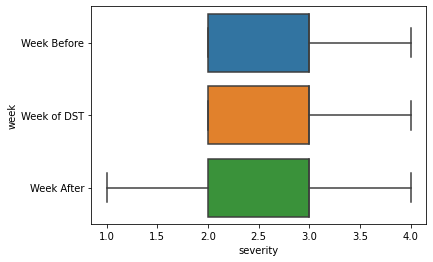

In [23]:
sns.boxplot(x=chi_df_spring_dst['severity'], y=chi_df_spring_dst['week'])
;

In [24]:
chi_df_spring_dst['week'].value_counts()

Week of DST    918
Week After     714
Week Before    540
Name: week, dtype: int64

In [33]:
pd.crosstab(chi_df_spring_dst['week'], chi_df_spring_dst['severity'])

severity,1,2,3,4
week,,,,
Week After,1,265,397,51
Week Before,0,183,304,53
Week of DST,0,395,471,52


In [34]:
chi_df_spring_dst['severity']

2.682780847145488

In [37]:
chi_df['severity'][chi_df['week'] == 10].mean()

2.759259259259259

In [38]:
chi_df['severity'][chi_df['week'] == 11].mean()

2.6263616557734206

In [39]:
chi_df['severity'][chi_df['week'] == 12].mean()

2.697478991596639

### Interpretation

* Based on the results of the ANOVA and Kruskall-Wallace tests we can see that there is a significant difference in the severity of traffic accidents before, during the week of DST, and after the week of DST.
* Based on the results from each multiple comparisons test we can see that there is a significant difference in severity score between the week before DST and the week of DST and the week of DST and the week after DST. Suggesting that something about the time change is leading to an increase in severity.